In [2]:
import numpy as np
import pandas as pd
import pulp
from scipy.spatial import distance_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
customer_count = 10 #顧客数（id=0はdepot）
vehicle_count = 4 #車両数
vehicle_capacity = 50 #車両容量

np.random.seed(seed=32)

#各顧客のx,y座標をDataFrameとして作成
df = pd.DataFrame({"x":np.random.randint(0,100, customer_count), 
                   "y":np.random.randint(0, 100, customer_count), 
                   "demand":np.random.randint(5, 20, customer_count)})

#id=0はdepotなので，demand=0にする
df.iloc[0].x = 50
df.iloc[0].y = 50
df.iloc[0].demand = 0

#コストとしてノード間の直線距離を求める
cost = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index).values

df.head()

,x,y,demand
0,50,50,0
1,43,4,15
2,5,11,9
3,54,81,7
4,62,3,9


(-10, 110)

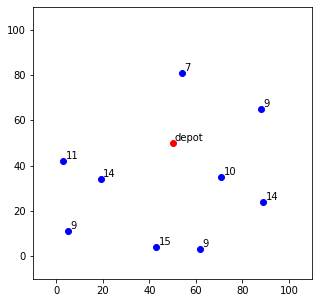

In [4]:
# depotと顧客の位置の可視化．添え字は荷物の量
plt.figure(figsize=(5,5))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i]+1, df.y[i]+1, "depot")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i]+1, df.y[i]+1, str(df.demand[i]))
plt.xlim([-10, 110])
plt.ylim([-10, 110])

In [5]:
for vehicle_count in range(1,vehicle_count+1):
    # 問題の宣言
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # 決定変数
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # 目的関数
    problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) for j in range(customer_count) for i in range (customer_count))

    # 制約
    # (2)式，各顧客の場所に訪れるのは1台の車両で1度である
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count) for k in range(vehicle_count)) == 1 

    #(3)式, depotから出発して，depotに戻ってくる
    for k in range(vehicle_count):
        # デポを出発した運搬車が必ず 1つの顧客から訪問を開始することを保証する制約条件
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        # 必ず 1 つの顧客から運搬車がデポへ到着すること保証する制約条件
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    #(4)式, ある顧客の所に来る車両数と出る車両数が同じ
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #(5)式, 各車両において最大容量を超えない
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    #(6)式, 部分巡回路除去制約
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    #最適化問題を解く
    #最適解が出たら終了
    if problem.solve() == 1:
        print('車両数:', vehicle_count)
        print('目的関数値:', pulp.value(problem.objective))
        break

車両数: 2
目的関数値: 381.32599213503414


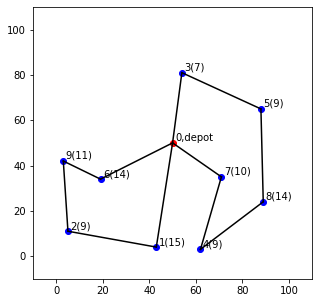

In [6]:
plt.figure(figsize=(5,5))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i]+1, df.y[i]+1, str(i)+",depot")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i]+1, df.y[i]+1, str(i)+"("+str(df.demand[i])+")")
plt.xlim([-10, 110])
plt.ylim([-10, 110])

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.x[i], df.x[j]], [df.y[i], df.y[j]], c="black")